(50000, 28, 28) (50000,)


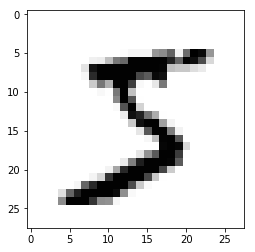

In [17]:
import sys
sys.path += ['week2']

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [18]:
from scipy.misc import imrotate, imresize

In [19]:
import tensorflow as tf
import numpy as np

## Preparation

Relaunch tensorboard, and import useful libraries.

In [20]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

'killall' is not recognized as an internal or external command,
operable program or batch file.


KeyboardInterrupt: 

# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [ ]:
y_train[:10]

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [21]:
rows = 28
cols = 28
classes = 10

s = tf.InteractiveSession()

with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [22]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [5]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
          2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
       [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
          1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
       [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
         -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
       ..., 
       [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
          2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
       [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
         -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
       [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
         -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32), array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
         5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
         8.76370585e-04,   2.40242618e-04,   2.61650217e-04,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
           2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
        [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
           1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
        [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
          -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
        ..., 
        [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
           2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
        [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
          -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
        [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
          -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32),
 array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
          5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
          8.76370585e-04,   2.40242618e-04,   2.61650

Finally, compute accuracy metrics when training the network.

In [8]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


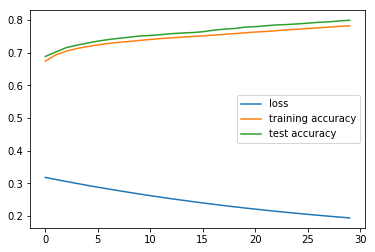

In [9]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [23]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.X_shuffled = self.X[idxs]
        self.y_shuffled = self.y[idxs]        
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_X = []
        res_y = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_X = self.X_shuffled[self.current_i:]
            res_y = self.y_shuffled[self.current_i:]
            self.reshuffle()
            res_X = np.append(res_X, self.X_shuffled[:rem], axis=0)
            res_y = np.append(res_y, self.y_shuffled[:rem])
            self.current_i = rem
        else:
            res_X = self.X_shuffled[self.current_i:end_i]
            res_y = self.y_shuffled[self.current_i:end_i]
            self.current_i = end_i
        
        return res_X, res_y

In [24]:
def train_network(iterations=2000, batch_size=1000, X_train=X_train, y_train=y_train):
    s.run(tf.global_variables_initializer())

    batcher = MiniBatchGenerator(X_train, y_train, batch_size)
    print(X_train.shape)
    print(y_train.shape)

    losses = []
    batch_train_accuracies = []

    train_accuracies = []
    test_accuracies = []

    for i in range(iterations):
        X_batch, y_batch = batcher.next()

        loss_i, accuracy_i, optimizer_i = s.run([
            loss, accuracy, optimizer
        ],  {input_x: X_batch, 
                         label_y: y_batch})

        if i % 100 == 0:        
            losses += [loss_i]
            batch_train_accuracies += [accuracy_i]

            accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_train, 
                 label_y: y_train})
            train_accuracies += [accuracy_i]

            test_accuracy_i = s.run(
                accuracy 
            ,  {input_x: X_test, 
                 label_y: y_test})
            test_accuracies += [test_accuracy_i]

            print("{} - loss: {}, train: {}, test: {}".format(i, loss_i, accuracy_i, test_accuracy_i))

    plt.figure()
    plt.plot(losses);
    plt.plot(batch_train_accuracies)
    plt.plot(train_accuracies)
    plt.plot(test_accuracies);
    plt.legend(['loss', 'batch train accuracy', 'training accuracy', 'test accuracy'])

    plt.figure()
    plt.plot(train_accuracies[-60:])
    plt.plot(test_accuracies[-60:]);
    plt.legend(['training accuracy', 'test accuracy'])

## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [25]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

layer_cnt = 0

def add_layer(in_, size, output_f):
    global layer_cnt
    
    W2 = tf.get_variable("weights{}".format(layer_cnt),
                         [in_.shape[1], size],
                         initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                         dtype=tf.float32)
    b2 = tf.get_variable("bias{}".format(layer_cnt),
                         [size],
                         initializer=tf.zeros_initializer(),
                         dtype=tf.float32)

    y2 = output_f(tf.matmul(in_, W2) + b2)
    
    layer_cnt += 1
    return y2

hidden_size = 30

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.4
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.sigmoid)
    y2 = add_layer(y1, 50, tf.nn.sigmoid)
    y3 = add_layer(y2, 50, tf.nn.sigmoid)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)
sigma 0.4


(50000, 28, 28)
(50000,)
0 - loss: 3.215146541595459, train: 0.1018800139427185, test: 0.10270000249147415
100 - loss: 0.46067526936531067, train: 0.8726599812507629, test: 0.8772000670433044
200 - loss: 0.27548667788505554, train: 0.9087199568748474, test: 0.9082000851631165
300 - loss: 0.24638532102108002, train: 0.9181998372077942, test: 0.9160001277923584
400 - loss: 0.1862402707338333, train: 0.9392998218536377, test: 0.9341000914573669
500 - loss: 0.20384620130062103, train: 0.9465598464012146, test: 0.9422000646591187
600 - loss: 0.14806333184242249, train: 0.9523597955703735, test: 0.9446001648902893
700 - loss: 0.1403612345457077, train: 0.9562598466873169, test: 0.9469001293182373
800 - loss: 0.10333552956581116, train: 0.9610798358917236, test: 0.9508001208305359
900 - loss: 0.10229596495628357, train: 0.9663398265838623, test: 0.9546000957489014
1000 - loss: 0.11420486867427826, train: 0.9691997766494751, test: 0.9548000693321228
1100 - loss: 0.09768536686897278, train: 0.9

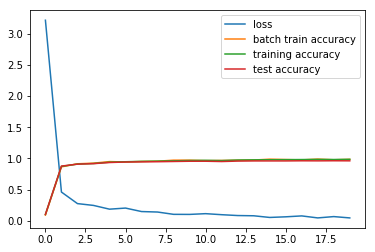

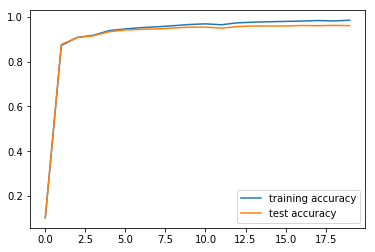

In [26]:
train_network()

(50000, 28, 28) (50000,)
sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.323793649673462, train: 0.17468002438545227, test: 0.18559998273849487
100 - loss: 0.4686724841594696, train: 0.8790199756622314, test: 0.884100079536438
200 - loss: 0.33508938550949097, train: 0.9049398899078369, test: 0.9089000821113586
300 - loss: 0.29901501536369324, train: 0.9189199209213257, test: 0.9218000769615173
400 - loss: 0.2714053988456726, train: 0.9326198697090149, test: 0.9349000453948975
500 - loss: 0.22015810012817383, train: 0.9405598640441895, test: 0.9411001205444336
600 - loss: 0.20142902433872223, train: 0.9468598961830139, test: 0.9449000954627991
700 - loss: 0.18413065373897552, train: 0.9487998485565186, test: 0.9450001120567322
800 - loss: 0.12288327515125275, train: 0.955659806728363, test: 0.9512001872062683
900 - loss: 0.15231968462467194, train: 0.9568597674369812, test: 0.9522001147270203
1000 - loss: 0.13564389944076538, train: 0.9623998403549194, test: 0.9544000625610352
1100 - los

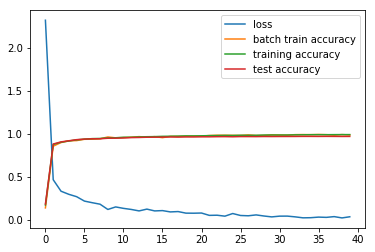

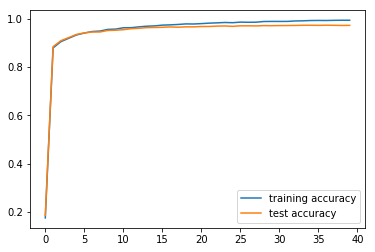

In [84]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.relu)
    y3 = add_layer(y1, 30, tf.nn.relu)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(.2).minimize(loss)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.358750820159912, train: 0.24418000876903534, test: 0.2549999952316284
100 - loss: 0.35960859060287476, train: 0.8978399038314819, test: 0.8945000171661377
200 - loss: 0.20253539085388184, train: 0.9495798349380493, test: 0.9471001029014587
300 - loss: 0.12143003195524216, train: 0.9588597416877747, test: 0.9531001448631287
400 - loss: 0.10087568312883377, train: 0.969639778137207, test: 0.9611001014709473
500 - loss: 0.07960417121648788, train: 0.9754797220230103, test: 0.9655001163482666
600 - loss: 0.05854121223092079, train: 0.9794598817825317, test: 0.9677001237869263
700 - loss: 0.045120276510715485, train: 0.9823598265647888, test: 0.9687000513076782
800 - loss: 0.060021646320819855, train: 0.9847397804260254, test: 0.9711000919342041
900 - loss: 0.045234955847263336, train: 0.9864998459815979, test: 0.9703001976013184
1000 - loss: 0.06345588713884354, train: 0.9888997673988342, test: 0.9714001417160034
1100 - loss: 0.027091227471828

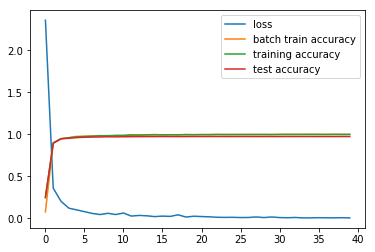

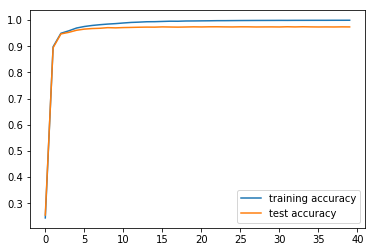

In [95]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.relu)
    y3 = add_layer(y1, 30, tf.nn.relu)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.313835859298706, train: 0.11830001324415207, test: 0.11369998753070831
100 - loss: 0.4229813814163208, train: 0.887179970741272, test: 0.8968999981880188
200 - loss: 0.3108082115650177, train: 0.9168399572372437, test: 0.9205001592636108
300 - loss: 0.2282305806875229, train: 0.9325198531150818, test: 0.9305000901222229
400 - loss: 0.20504359900951385, train: 0.9391998052597046, test: 0.9383000731468201
500 - loss: 0.18206696212291718, train: 0.9463797807693481, test: 0.9440001845359802
600 - loss: 0.16005688905715942, train: 0.9518198370933533, test: 0.9469000697135925
700 - loss: 0.17256346344947815, train: 0.954579770565033, test: 0.94840008020401
800 - loss: 0.14762189984321594, train: 0.9586398005485535, test: 0.9515001177787781
900 - loss: 0.10273606330156326, train: 0.9617597460746765, test: 0.9544001817703247
1000 - loss: 0.13239598274230957, train: 0.9636598825454712, test: 0.9573001861572266
1100 - loss: 0.11836736649274826, trai

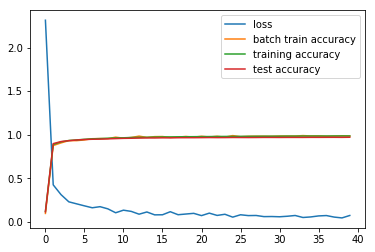

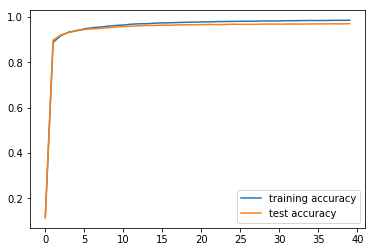

In [94]:
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 50, tf.nn.relu)
    y3 = add_layer(y1, 30, tf.nn.relu)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .3
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.304302453994751, train: 0.09164000302553177, test: 0.09339999407529831
100 - loss: 0.4226233959197998, train: 0.8559800982475281, test: 0.8659000992774963
200 - loss: 0.3075295388698578, train: 0.8909599781036377, test: 0.894800066947937
300 - loss: 0.17967678606510162, train: 0.9369398355484009, test: 0.937900185585022
400 - loss: 0.1375850886106491, train: 0.947199821472168, test: 0.9451001286506653
500 - loss: 0.1371971070766449, train: 0.9542997479438782, test: 0.949700117111206
600 - loss: 0.12528927624225616, train: 0.9590398073196411, test: 0.9548001885414124
700 - loss: 0.09874507784843445, train: 0.9632598161697388, test: 0.9591001868247986
800 - loss: 0.13883715867996216, train: 0.9653598070144653, test: 0.9602001309394836
900 - loss: 0.09218638390302658, train: 0.9685598015785217, test: 0.9620001316070557
1000 - loss: 0.11111657321453094, train: 0.9697397351264954, test: 0.9623001217842102
1100 - loss: 0.09228108823299408, train

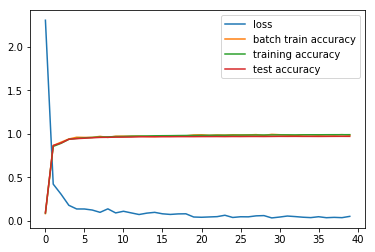

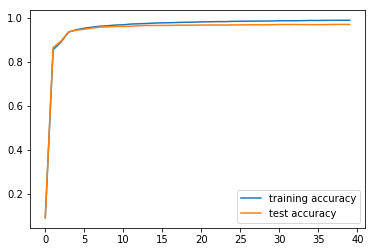

In [96]:
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 50, tf.nn.relu)
    y_prev = add_layer(y1, 50, tf.nn.relu)
    y3 = add_layer(y_prev, 30, tf.nn.relu)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .3
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.331427574157715, train: 0.27542001008987427, test: 0.2893999516963959
100 - loss: 0.28556787967681885, train: 0.9178199172019958, test: 0.9219000935554504
200 - loss: 0.22677850723266602, train: 0.9386199116706848, test: 0.9406001567840576
300 - loss: 0.19385609030723572, train: 0.951279878616333, test: 0.951400101184845
400 - loss: 0.1491268426179886, train: 0.9566998481750488, test: 0.9549001455307007
500 - loss: 0.1245587021112442, train: 0.9636597633361816, test: 0.9605001211166382
600 - loss: 0.12468921393156052, train: 0.9659998416900635, test: 0.9622001051902771
700 - loss: 0.13010473549365997, train: 0.9692597985267639, test: 0.9640000462532043
800 - loss: 0.0897693783044815, train: 0.971379816532135, test: 0.9648001194000244
900 - loss: 0.08727774024009705, train: 0.9728797674179077, test: 0.9660001397132874
1000 - loss: 0.07014494389295578, train: 0.9754596948623657, test: 0.9684000611305237
1100 - loss: 0.07609695196151733, trai

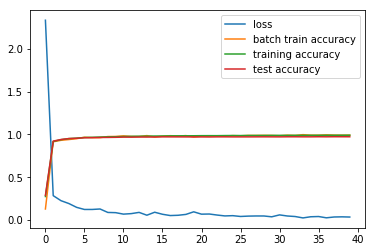

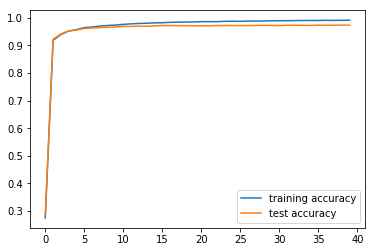

In [90]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 50, tf.nn.relu)
    y = add_layer(y1, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.404158592224121, train: 0.14100003242492676, test: 0.1437000036239624
100 - loss: 0.4279075860977173, train: 0.8951199054718018, test: 0.8972001075744629
200 - loss: 0.2995057702064514, train: 0.9213599562644958, test: 0.9230000972747803
300 - loss: 0.22088351845741272, train: 0.9345998167991638, test: 0.9322000741958618
400 - loss: 0.19690005481243134, train: 0.9452998638153076, test: 0.9434001445770264
500 - loss: 0.17893782258033752, train: 0.9536798596382141, test: 0.9494000673294067
600 - loss: 0.12351535260677338, train: 0.958399772644043, test: 0.9531000852584839
700 - loss: 0.1343385875225067, train: 0.9627197980880737, test: 0.9565001726150513
800 - loss: 0.12160132825374603, train: 0.9656398296356201, test: 0.9595001339912415
900 - loss: 0.1040712296962738, train: 0.9674597978591919, test: 0.9606001377105713
1000 - loss: 0.1001540794968605, train: 0.9710198640823364, test: 0.9626001119613647
1100 - loss: 0.10269249975681305, trai

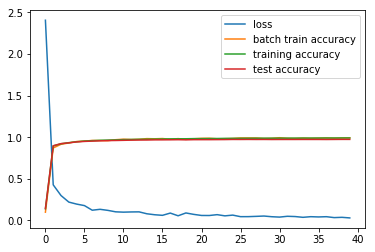

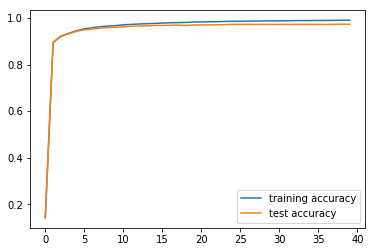

In [91]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.relu)
    y1 = add_layer(y1, 50, tf.nn.sigmoid)
    y = add_layer(y1, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.3530051708221436, train: 0.1000400111079216, test: 0.09549999237060547
100 - loss: 0.48525702953338623, train: 0.8701399564743042, test: 0.8796000480651855
200 - loss: 0.28636792302131653, train: 0.9105399250984192, test: 0.912300169467926
300 - loss: 0.24915003776550293, train: 0.9273399114608765, test: 0.9279000759124756
400 - loss: 0.2021200805902481, train: 0.9392598867416382, test: 0.9386001229286194
500 - loss: 0.1826624572277069, train: 0.9458798170089722, test: 0.9450000524520874
600 - loss: 0.17643889784812927, train: 0.9524598717689514, test: 0.9507002234458923
700 - loss: 0.16245137155056, train: 0.9564998149871826, test: 0.952700138092041
800 - loss: 0.1598379760980606, train: 0.9606398940086365, test: 0.9545001983642578
900 - loss: 0.12368938326835632, train: 0.964079737663269, test: 0.9581000804901123
1000 - loss: 0.11464741080999374, train: 0.9673398733139038, test: 0.9592001438140869
1100 - loss: 0.11334897577762604, train:

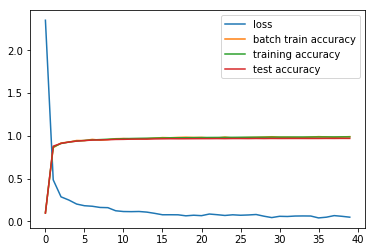

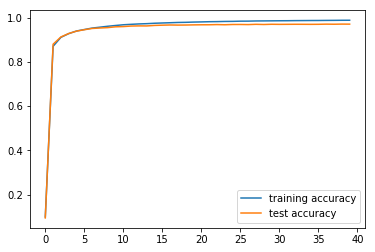

In [92]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 50, tf.nn.relu)
    y1 = add_layer(y1, 30, tf.nn.sigmoid)
    y = add_layer(y1, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

sigma 0.1
(50000, 28, 28)
(50000,)
0 - loss: 2.328120231628418, train: 0.09052000194787979, test: 0.08810000121593475
100 - loss: 0.5220832824707031, train: 0.8560400605201721, test: 0.8603001236915588
200 - loss: 0.23787599802017212, train: 0.9305598735809326, test: 0.9277001619338989
300 - loss: 0.20905236899852753, train: 0.9467798471450806, test: 0.9432001113891602
400 - loss: 0.1892421990633011, train: 0.9538998007774353, test: 0.9495001435279846
500 - loss: 0.14363829791545868, train: 0.9651198387145996, test: 0.9587000608444214
600 - loss: 0.10474270582199097, train: 0.9709397554397583, test: 0.9620001316070557
700 - loss: 0.09127457439899445, train: 0.9742397665977478, test: 0.9615001678466797
800 - loss: 0.08128661662340164, train: 0.9798197746276855, test: 0.966400146484375
900 - loss: 0.04653485119342804, train: 0.9821197986602783, test: 0.9672000408172607
1000 - loss: 0.04236995801329613, train: 0.9842597246170044, test: 0.9684001803398132
1100 - loss: 0.04067005217075348, 

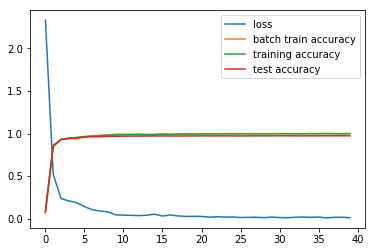

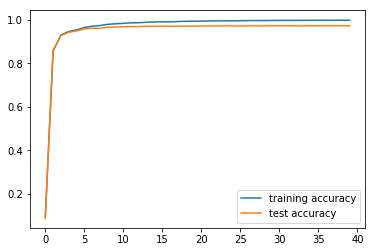

In [93]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.relu)
    y1 = add_layer(y1, 50, tf.nn.relu)
    y1 = add_layer(y1, 30, tf.nn.sigmoid)
    y = add_layer(y1, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000)

In [7]:
?imresize

In [10]:
img = imresize(X_train[0], 110)
img.shape

(30, 30)

In [13]:
offset = int((img.shape[0] - 28)/2)
img = img[offset:offset+28, offset:offset+28]

In [ ]:
expanded_X_train = []
expanded_y_train = []

def img_resize(img, percent):
    img_ = imresize(img, percent)
    offset = int((img_.shape[0] - 28) / 2)
    return img_[offset:offset+28, offset:offset+28]

for i in range(len(X_train)):
    img = X_train[i]
    img_class = y_train[i]

    expanded_X_train += [img]
    expanded_y_train += [img_class]

    for angle in [5, -5]:
        img_ = imrotate(img, angle)
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
    for scale in [110, 120]:
        img_ = img_resize(img, scale)
        assert img_.shape[0] == 28
        expanded_X_train += [img_]
        expanded_y_train += [img_class]
    
expanded_X_train = np.array(expanded_X_train)
expanded_y_train = np.array(expanded_y_train)


In [ ]:
tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.1
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.relu)
    y1 = add_layer(x, 50, tf.nn.relu)
    y1 = add_layer(y1, 30, tf.nn.sigmoid)
    y = add_layer(y1, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = .8
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    s.run(tf.global_variables_initializer())

train_network(iterations=4000, batch_size=100, X_train=expanded_X_train, y_train=expanded_y_train)

sigma 0.1
(250000, 28, 28)
(250000,)
0 - loss: 2.324079990386963, train: 0.15706801414489746, test: 0.12209998816251755
100 - loss: 1.9249851703643799, train: 0.36963605880737305, test: 0.3980999290943146
200 - loss: 1.9911494255065918, train: 0.34447208046913147, test: 0.3593999147415161
300 - loss: 2.234330177307129, train: 0.1503080129623413, test: 0.1581999957561493
400 - loss: 2.3235080242156982, train: 0.17662805318832397, test: 0.16940000653266907
500 - loss: 2.4015207290649414, train: 0.09828801453113556, test: 0.09829998761415482
600 - loss: 2.321381092071533, train: 0.10087601840496063, test: 0.10099999606609344
700 - loss: 2.4293370246887207, train: 0.09795600920915604, test: 0.09749999642372131
800 - loss: 2.1761679649353027, train: 0.23618802428245544, test: 0.2579999566078186
900 - loss: 2.0761284828186035, train: 0.24033205211162567, test: 0.23439998924732208
1000 - loss: 2.2432260513305664, train: 0.1550440490245819, test: 0.1418999880552292
1100 - loss: 2.1881093978881

In [38]:
with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 0.4
    print("sigma", sigma)
  
    # input layer
    y1 = add_layer(x, 100, tf.nn.sigmoid)
    y2 = add_layer(y1, 50, tf.nn.sigmoid)
    y3 = add_layer(y2, 50, tf.nn.sigmoid)
    y = add_layer(y3, 10, tf.nn.softmax)

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(2.).minimize(loss)
    
    s.run(tf.global_variables_initializer())
    
train_network(iterations=2000, X_train=expanded_X_train, y_train=expanded_y_train)

sigma 0.4
(300000, 28, 28)
(300000,)
0 - loss: 3.7510318756103516, train: 0.12272001057863235, test: 0.12049999088048935
100 - loss: 0.7509714961051941, train: 0.7530027627944946, test: 0.7866000533103943
200 - loss: 0.7458539605140686, train: 0.74561607837677, test: 0.8072999715805054
300 - loss: 0.509824812412262, train: 0.8273857831954956, test: 0.8715000748634338
400 - loss: 0.46102026104927063, train: 0.8569589853286743, test: 0.8963000774383545
500 - loss: 0.5072886943817139, train: 0.8254258632659912, test: 0.8705000877380371
600 - loss: 0.5288138389587402, train: 0.85170578956604, test: 0.8949001431465149
700 - loss: 0.5652925968170166, train: 0.8178358674049377, test: 0.8560000658035278
800 - loss: 0.39050981402397156, train: 0.8794956803321838, test: 0.9083001017570496
900 - loss: 0.5877676606178284, train: 0.7918359041213989, test: 0.8357000946998596
1000 - loss: 0.4329912066459656, train: 0.8771156072616577, test: 0.9093000292778015
1100 - loss: 0.4314578175544739, train: 0

KeyboardInterrupt: 